# Preamble

Ignore the errors raised because of nb-black

In [1]:
cd ../

/Users/ashkanaleali/w/infer_struct


In [2]:
pwd

'/Users/ashkanaleali/w/infer_struct'

In [78]:
%load_ext lab_black
%matplotlib inline
%load_ext autoreload
%autoreload 2
%load_ext autotime

import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import pyplot_themes as themes
import array_to_latex as a2l
import os
import numpy as np
import pandas as pd
import networkx as nx


mpl.rcParams.update({"font.size": 12, "figure.figsize": (7, 5), "figure.dpi": 100})
# mpl.rcParams['figure.dpi'] = 300
plt.style.use("dark_background")
# themes.theme_solarized(scheme="dark", figsize=(7, 5), fontsize=12)
mpl.rcParams["axes.labelcolor"] = "#808080"

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 18.8 ms (started: 2021-03-31 21:17:27 -05:00)


In [116]:
from infer_struct.data import PowerGridSimpleExample
from infer_struct import util

time: 3.03 ms (started: 2021-03-31 23:02:10 -05:00)


# Data

This notebook is just to see how to load the data Amir has provided.

In [6]:
node_number = 9
data_dir = "../data/Network_raw_data_Ashkan/"
example_id = f"{node_number}_nodes"

time: 3.46 ms (started: 2021-03-31 12:58:16 -05:00)


In [7]:
ex = PowerGridSimpleExample(node_number)

time: 23.9 ms (started: 2021-03-31 12:58:16 -05:00)


+ There are 2 $nxn$ matrices and 6 vectors for each example. The vectors have length < $n$ and the missing elements are treated as zero.
+ Each vector is given by a tuple where the first element is the index of the element -- sparse matrix representation?


The PowerGridSimpleExample do some normalizations and also provide weighted network data structures:

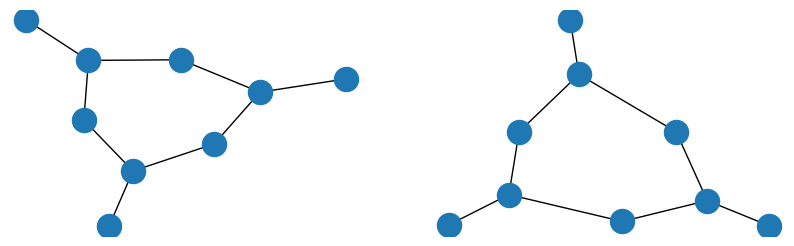

time: 154 ms (started: 2021-03-31 18:51:22 -05:00)


In [30]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 3))
nx.draw(ex.Gbus_theta, ax=ax[0])
nx.draw(ex.Gbus_mag, ax=ax[1])

It would be nice to figure out a way to add theta and mag as different attributes of the same undirected graph.

The equation of power grid has three components:

1. $A_i = PG_i - PL_i$
2. $B_i = v_i^2 Y_{ii} \cos(\theta_{ii})$
3. $C_i = \sum_{j=2}^n v_i v_j Y_{ij} \cos(\delta_i - \delta_j - \theta_{ij})$

and we have $A_i = B_i + C_i\ (\forall i \in \{0, ..., n - 1\})$

$A$ and $B$ are easy to vectorize. Let's focus on C.

There are two outer products:
1. $v \otimes v$
2. $\delta \ominus \delta$

where $\otimes$ and $\ominus$ denote outer product w.r.t. $\times$ and $-$ operators.

In [185]:
def power_grid_equation_lhs(pg, pl):
    """Compute the A. equation"""
    return pg - pl

    """Compute the B. equation"""
    return np.diag(Y) * np.cos(np.diag(Theta)) * (v ** 2)


def power_grid_equation_rhs(Y, Theta, v, delta):
    """Compute the right hand side of the power grid equation"""
    return np.diag(
        np.multiply(np.multiply.outer(v, v), Y)
        @ np.cos(np.subtract.outer(delta, delta) - Theta)
    )

time: 13.2 ms (started: 2021-04-01 14:18:28 -05:00)


In [186]:
power_grid_equation_rhs(ex.Ybus_mag, ex.Ybus_theta, ex.v, ex.d)

array([-0.71967375, -1.63010559, -0.85015657,  0.12685005,  1.10971496,
        0.8022292 ,  0.1542487 ,  0.93126026,  0.12727834])

time: 7.56 ms (started: 2021-04-01 14:18:28 -05:00)


In [177]:
power_grid_equation_lhs(ex.pg, ex.pl)

array([  71.955,  163.   ,   85.   ,    0.   , -125.   ,  -90.   ,
          0.   , -100.   ,    0.   ])

time: 5.79 ms (started: 2021-04-01 14:08:27 -05:00)


hmm. the values should match. let's implement the for loop algorithm and see if that also produces garbage

In [206]:
def power_grid_equation_lhs2(pg, pl):
    res = np.zeros_like(pg)
    for i in range(len(res)):
        res[i] = pg[i] - pl[i]
    return res


def power_grid_equation_rhs2(Y, Theta, v, delta):
    res = np.zeros_like(v)
    for i in range(len(res)):
        a = v[i] * Y[i, i] * math.cos(Theta[i, i])
        b = 0
        for j in range(len(res)):
            if j != i:
                b += v[i] * v[j] * Y[i, j] * math.cos(delta[i] - delta[j] - Theta[i, j])
        res[i] = a + b
    return res

time: 17.1 ms (started: 2021-04-01 14:28:39 -05:00)


In [208]:
power_grid_equation_rhs2(
    ex.Ybus_mag, ex.Ybus_theta, ex.v, ex.d
) - power_grid_equation_lhs2(ex.pg, ex.pl)

array([-7.12355796e+01, -1.61370128e+02, -8.41500944e+01,  4.28911066e-02,
        1.23853496e+02,  8.91778979e+01,  1.19401009e-02,  9.90389989e+01,
       -8.03836363e-03])

time: 10.2 ms (started: 2021-04-01 14:29:18 -05:00)


9

time: 4.87 ms (started: 2021-04-01 14:28:04 -05:00)
